In [1]:
import os
os.chdir('siesta_2')
import numpy as np
from sisl import *
import matplotlib.pyplot as plt
%matplotlib inline

# Siesta ---  graphene

This tutorial will describe a complete walk-through of a large fraction of the `sisl` functionalities that may be related to the [Siesta code](https://gitlab.com/siesta-project/siesta).

Contrary to the $\mathrm H_2\mathrm O$ system this tutorial will emphasize the usefulness of performing bandstructures etc. directly in Python using sisl.

## Creating the geometry

Our system of interest will be the smallest graphene cell. Instead of defining the atomic positions, the carbon atoms and supercell for graphene, we use a default implementation of graphene in `sisl`. There are a small selection of the typical geometries, including graphene.

In [2]:
graphene = geom.graphene(1.44)

Let us plot the geometry.

<AxesSubplot:xlabel='Ang', ylabel='Ang'>

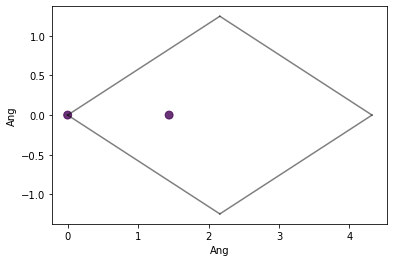

In [3]:
plot(graphene)

Now we need to create the input fdf file for Siesta:

In [4]:
open('RUN.fdf', 'w').write("""%include STRUCT.fdf
SystemLabel siesta_2
PAO.BasisSize SZP
MeshCutoff 250. Ry
CDF.Save true
CDF.Compress 9
SaveHS true
SaveRho true
%block kgrid.MonkhorstPack
  61  1 1 0.
   1 61 1 0.
   0  0 1 0.
%endblock
""")
graphene.write('STRUCT.fdf')

## Creating the electronic structure

Before proceeding, run Siesta to calculate the ground state electronic structure.

After having completed the Siesta run we may read the Hamiltonian to manipulate and extract different information.
After reading the Hamiltonian it is obvious that a great deal of new data has been associated with the Hamiltonian.

In [5]:
fdf = get_sile('RUN.fdf')
H = fdf.read_hamiltonian()
print(H)

Hamiltonian{non-zero: 5994, orthogonal: False,
 Spin{unpolarized, kind=f},
 Geometry{na: 2, no: 18,
  Atoms{species: 1,
   Atom{C, Z: 6, mass(au): 12.01000, maxR: 2.57730,
    AtomicOrbital{2sZ1, q0: 2.0, SphericalOrbital{l: 0, R: 2.2183, q0: 2.0}},
    AtomicOrbital{2pyZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.5773, q0: 2.0}},
    AtomicOrbital{2pzZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.5773, q0: 2.0}},
    AtomicOrbital{2pxZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.5773, q0: 2.0}},
    AtomicOrbital{2dxyZ1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.5773, q0: 0.0}},
    AtomicOrbital{2dyzZ1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.5773, q0: 0.0}},
    AtomicOrbital{2dz2Z1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.5773, q0: 0.0}},
    AtomicOrbital{2dxzZ1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.5773, q0: 0.0}},
    AtomicOrbital{2dx2-y2Z1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.5773, q0: 0.0}}
   }: 2,
  },
  maxR: 2.57730,
  SuperCell{nsc: [5 5 1],
   A

## Calculating DOS and PDOS

When we are dealing with periodic structures (such as graphene) it is imperative to calculate the density of states in a simple and efficient manner. Below we will calculate the DOS for a variety of Monkhorst-Pack grids to check the convergence of the DOS (it shouldn't take more than a minute):

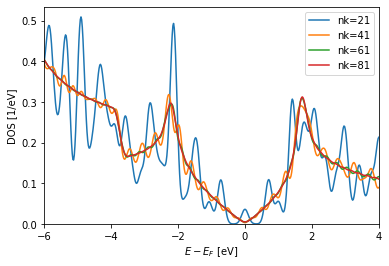

In [6]:
E = np.linspace(-6, 4, 500)
for nk in [21, 41, 61, 81]:
    bz = MonkhorstPack(H, [nk, nk, 1])
    plt.plot(E, bz.apply.average.DOS(E), label='nk={}'.format(nk));
plt.xlim(E[0], E[-1]); plt.ylim(0, None)
plt.xlabel(r'$E - E_F$ [eV]')
plt.ylabel(r'DOS [1/eV]')
plt.legend();

We see that the k-points are converged for approximately 61 k-points using the default smearing method. The default smearing method is the Gaussian smearing technique with $\sigma=0.1\mathrm{eV}$. Note that intrinsically the `MonkhorstPack` grid assumes time-reversal symmetry. I.e. $\mathbf k \equiv -\mathbf k$.

Now we may use the Monkhorst-Pack grid for 81 points to find the projected DOS for some of the orbitals.

Orbital index of s: [0]
Orbital index of p_x and p_y: [1, 3]
Orbital index of p_z: [2]


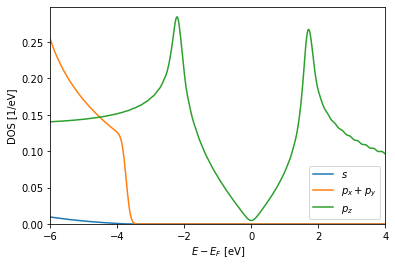

In [7]:
bz = MonkhorstPack(H, [81, 81, 1])
idx_s = list()
idx_pxy = list()
idx_pz = list()
for i, orb in enumerate(H.geometry.atoms[0]):
    if orb.l == 0:
        idx_s.append(i)
    elif orb.l == 1 and (orb.m in [-1, 1]):
        idx_pxy.append(i)
    elif orb.l == 1 and orb.m == 0:
        idx_pz.append(i)
print('Orbital index of s: {}'.format(idx_s))
print('Orbital index of p_x and p_y: {}'.format(idx_pxy))
print('Orbital index of p_z: {}'.format(idx_pz))
# Get all orbitals
all_s = np.add.outer(H.geometry.a2o([0, 1]), idx_s).ravel()
all_pxy = np.add.outer(H.geometry.a2o([0, 1]), idx_pxy).ravel()
all_pz = np.add.outer(H.geometry.a2o([0, 1]), idx_pz).ravel()
def wrap(PDOS):
    pdos_s = PDOS[all_s, :].sum(0)
    pdos_pxy = PDOS[all_pxy, :].sum(0)
    pdos_pz = PDOS[all_pz, :].sum(0)
    return np.stack((pdos_s, pdos_pxy, pdos_pz))
pDOS = bz.apply.average.PDOS(E, wrap=wrap)
plt.plot(E, pDOS[0, :], label='$s$');
plt.plot(E, pDOS[1, :], label='$p_x+p_y$');
plt.plot(E, pDOS[2, :], label=r'$p_z$');
plt.xlim(E[0], E[-1]); plt.ylim(0, None)
plt.xlabel(r'$E - E_F$ [eV]')
plt.ylabel(r'DOS [1/eV]')
plt.legend();

As seen the $p_z$ orbitals are responsible for the DOS in a broad range of energies around the Fermi-level. This is one reason for the tight-binding models success with respect to graphene.

Another way to gain information is via the so-called *fat-bands* which basically is the PDOS scaling (no broadening) on each band for the quantities we are interested in. To plot the fat-bands we need the band-structure and a projection of each state onto the requested orbitals.

In [8]:
weight_s = list()
weight_pxy = list()
weight_pz = list()
def wrap_fatbands(eigenstate):
    # The eigenstate object has several features.
    # For now we will simply calculate the <psi_i| S(k) | psi_i> weight for
    # the orbitals we are interested in.
    norm2 = eigenstate.norm2(sum=False)
    weight_s.append(norm2[:, all_s].sum(-1))
    weight_pxy.append(norm2[:, all_pxy].sum(-1))
    weight_pz.append(norm2[:, all_pz].sum(-1))
    return eigenstate.eig
# Define the band-structure
bz = BandStructure(H, [[0] * 3, [2./3, 1./3, 0], [0.5, 0.5, 0], [1] * 3], 400, 
                   name=[r'$\Gamma$', r'$K$', r'$M$', r'$\Gamma$'])

# Calculate all eigenvalues
eig = bz.apply.array.eigenstate(wrap=wrap_fatbands).T
weight_s = np.array(weight_s).T
weight_pxy = np.array(weight_pxy).T
weight_pz = np.array(weight_pz).T

Finally we plot the fat-bands. Our plots split each of the orbitals contributions into their separate fat band. Thus one can see details on multiple orbital contributions for each band.

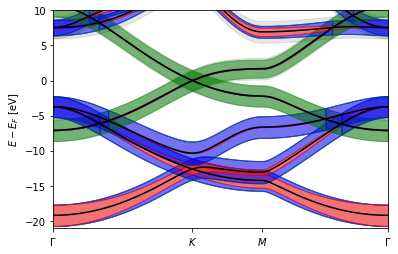

In [9]:
linear_k, k_tick, k_label = bz.lineark(True)

Emin, Emax = -21, 10
# This is to determine the width of the fat-bands
# The width of the fat-bands is dependent on the energy range and also on the variety
# of contributions.
dE = (Emax - Emin) / 20.
plt.ylabel(r'$E-E_F$ [eV]')
plt.xlim(linear_k[0], linear_k[-1]);
plt.xticks(k_tick, k_label);
plt.ylim(Emin, Emax);

# Now plot the bands
for i, e in enumerate(eig):
    s = np.abs(weight_s[i, :] * dE)
    pxy = np.abs(weight_pxy[i, :] * dE)
    pz = np.abs(weight_pz[i, :] * dE)
    plt.plot(linear_k, e, color='k'); # black-line (band-structure)
    # Full fat-band
    plt.fill_between(linear_k, e - dE, e + dE, color='k', alpha=0.1);
    # pz
    plt.fill_between(linear_k, e + (s + pxy), e + (s + pxy + pz), color='g', alpha=0.5);
    plt.fill_between(linear_k, e - (s + pxy + pz), e - (s + pxy), color='g', alpha=0.5);
    # pxy
    plt.fill_between(linear_k, e + (s), e + (s + pxy), color='b', alpha=0.5);
    plt.fill_between(linear_k, e - (s), e - (s + pxy), color='b', alpha=0.5);
    # s
    plt.fill_between(linear_k, e - (s), e + (s), color='r', alpha=0.5);

- all, gray
- $p_z$, green
- $s$, red
- $p_x+p_y$, blue

## Hamiltonian eigenstates

At this point we have plotted the $k$-averaged DOS, PDOS. We have also plotted the fat-bands (and thus the band-structure). 

In addition to these things we can plot the real-space eigenstates. We first plot the $\Gamma$-point for the first 2x2 unit-cell. This $k$-point has complete unit-cell periodicity and thus the plotted wavefunction should be fully periodic along all directions.

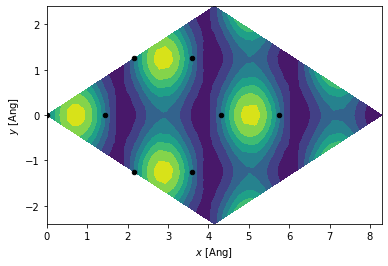

In [10]:
es = H.eigenstate()
idx_valence = (es.eig > 0).nonzero()[0][0] - 1
# Only select the valence band state
es = es.sub(idx_valence)

# Generate a grid encompassing a 2x2 graphene unit-cell
g = Grid(0.2, sc=H.geometry.sc.tile(2, 0).tile(2, 1))
# Calculate the real-space wavefunctions
es.wavefunction(g)

# Extract the wavefunction a few Ang above the graphene plane
# To do this we need to find the index of the corresponding z-plane.
# The Grid.index method is useful in this regard.
xyz = H.geometry.xyz[0, :].copy()
xyz[2] += 1.
z_idx = g.index(xyz, axis=2)
x, y = np.mgrid[:g.shape[0], :g.shape[1]]
x, y = x * g.dcell[0, 0] + y * g.dcell[1, 0], x * g.dcell[0, 1] + y * g.dcell[1, 1]
plt.contourf(x, y, g.grid[:, :, z_idx]);
xyz = H.geometry.tile(2, 0).tile(2, 1).xyz
plt.scatter(xyz[:, 0], xyz[:, 1], 20, c='k');
plt.xlabel(r'$x$ [Ang]');
plt.ylabel(r'$y$ [Ang]');

We will now try and plot the real-space wavefunction for a finite $k$. By choosing the $[1/2, 0, 0]$ point we know it must have a periodicity of 2 along the first lattice vector (this lattice vector is pointing right-up), and full periodicity along the second lattice vector. Since we have a finite $k$ the grid data-type *must* be complex because the eigenstates have complex components. And thus we will plot both the real and imaginary part.

info:0: SislInfo: wavefunction: k != Gamma is currently untested!


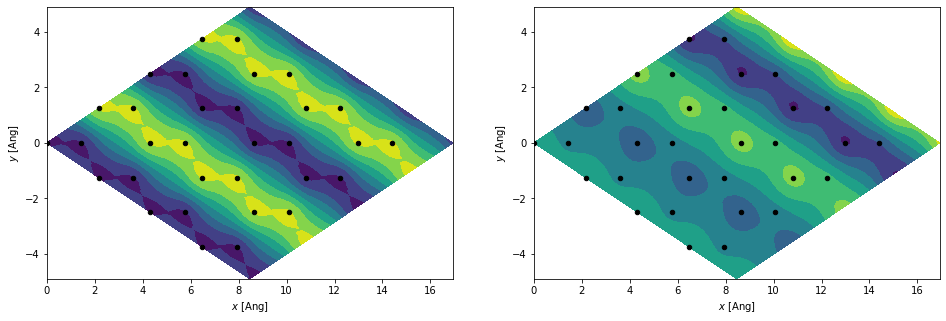

In [11]:
_, axs = plt.subplots(1, 2, figsize=(16, 5))
es = H.eigenstate([1./2, 0, 0])
idx_valence = (es.eig > 0).nonzero()[0][0] - 1
es = es.sub(idx_valence)
g = Grid(0.2, dtype=np.complex128, sc=H.geometry.sc.tile(4, 0).tile(4, 1))
es.wavefunction(g)
x, y = np.mgrid[:g.shape[0], :g.shape[1]]
x, y = x * g.dcell[0, 0] + y * g.dcell[1, 0], x * g.dcell[0, 1] + y * g.dcell[1, 1]
axs[0].contourf(x, y, g.grid[:, :, z_idx].real);
axs[1].contourf(x, y, g.grid[:, :, z_idx].imag);
xyz = H.geometry.tile(4, 0).tile(4, 1).xyz
for ax in axs:
    ax.scatter(xyz[:, 0], xyz[:, 1], 20, c='k');
    ax.set_xlabel(r'$x$ [Ang]');
    ax.set_ylabel(r'$y$ [Ang]');